In [1]:
%pylab inline
import pandas as pd
import time
#import numpy as np
import pickle
import joblib
import copy as cp
from joblib import Parallel, delayed
import os
import csv
from pandas import *
import datetime as dt
from datetime import date, datetime, timedelta
from sklearn import svm, preprocessing
from collections import Counter
from sklearn import linear_model as lm
import math as math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from ggplot import *
from sklearn.linear_model import SGDRegressor
from scipy import stats
from scipy.stats import binned_statistic, binned_statistic_dd
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier

plt.style.use('seaborn-white')
pandas.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [2]:
feats = ['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Weight', 
         'Heart Rate', 'Respiratory Rate','$O_2$ saturation pulseoxymetry', 'NI Blood Pressure (Mean)', 
        '$O_2$ Flow', 'Inspired $O_2$ Fraction', 'Arterial $CO_2$ Pressure', 'Arterial pH', 'Arterial $O_2$ pressure', 
        'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure', 'Plateau Pressure', 'Minute Volume', 
        'Tidal Volume', 'PEEP set', 'Creatinine', 'Hematocrit', 'Blood Urea Nitrogen (BUN)',
         'Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Propofol','Fentanyl', 'Dexmedetomidine (Precedex)', 
        'Morphine Sulfate','Hydromorphone (Dilaudid)', 'Lorazepam (Ativan)',
        'Duration', 'Intubations']

In [3]:
with open("pickles/preppedBaseFrames2.pkl",'rb') as f: 
    allSamples2, hadmsList, currStates, nextStates, actions, rewards = pickle.load(f)

allSamples = {}
for i in range(len(allSamples2)):
    h = allSamples2[i]['hadm']
    allSamples[h] = allSamples2[i]

In [4]:
currStates = np.concatenate(currStates)
nextStates = np.concatenate(nextStates)
ventActions = np.transpose(actions)[0]
inputActions = np.transpose(actions)[9]
inputActionsign = (sign(inputActions))
hadms = unique(hadmsList)
scaler = StandardScaler() 
scaler.fit(currStates)
currStatesScaled = scaler.transform(currStates)
nextStatesScaled = scaler.transform(nextStates)

In [5]:
allsums = ([sum([0.2, 0.5, 0.1, 0.2, 0.1, 0.1, 1, 1] * np.transpose((np.transpose(currStatesScaled)[24:32]))[i]) 
            for i in range(len(currStates))])
bins = np.array([-1000.0, -0.8, -0.4, -0.2, 0, 0.2, 0.4, 0.8, 1000.0])
inds = np.digitize(allsums, bins)
sedActions = inds
#for n in range(179):
#    print bins[inds[n]-1], "<=", allsums[n], "<", bins[inds[n]] 

In [6]:
#feats[24:32]
changepoints = zeros(len(hadmsList))
for i in range(1,len(hadmsList)):
    if hadmsList[i] != hadmsList[i-1]:
        changepoints[i] = 1
st = 0
for ed in np.concatenate(np.where(changepoints!=0))[0:10]:
    sums = ([sum([0.2, 0.5, 0.1, 0.2, 0.1, 0.1, 1, 1] * np.transpose((np.transpose(currStatesScaled)[24:32]))[i]) 
             for i in range(st,ed)])
    st = ed
    #print ed, max(sums) - min(sums)
    #plot(sums)
    #figure()

In [7]:
np.concatenate(np.where(changepoints!=0))[0:10]

array([ 179,  366,  460,  507,  877,  989, 1219, 1249, 1278, 1311])

In [8]:
############ FQI

# Hacks:
# 1. "Countersamples" with negative reward for vent=off in the first 5 hours
# 2. Upweight true samples from vent=off so these are often seen
# 3. Feature subset 0:24, 34 (excludes sedative dosages) --- explore with REM-style experiments?
# 4. Runs with just possible actions [0,1] (vent actions)
# 5. Setting discount factor

In [12]:
counterActions = [(0,0), (0,1), (0,-1)]
counterStates = []
counterNext = []
for h in hadms[:1500]:
    for s in range(len(allSamples[h]['currStates'])):
        dur =  np.concatenate(allSamples[h]['currStates'][s])[32]
        vent =  (allSamples[h]['actions'][s])[0]
        if dur > 0 and dur <= 6 and vent == 1:
            #print np.concatenate(allSamples[h]['currStates'][s])[32], (allSamples[h]['actions'][s])[0]
            counterStates.append(allSamples[h]['currStates'][s])
            counterNext.append(allSamples[h]['nextStates'][s])
counterRewards = np.ones((len(counterStates),1)) *-1.5
counterSamples = np.hstack([scaler.transform(np.concatenate(counterStates)), np.zeros((len(counterStates),1))])


In [13]:
# for 6 actions
counterSamples = np.vstack([np.hstack([scaler.transform(np.concatenate(counterStates)), np.ones((len(counterStates),2)) *counterActions[0]]), 
np.hstack([scaler.transform(np.concatenate(counterStates)), np.ones((len(counterStates),2)) *counterActions[1]]),
np.hstack([scaler.transform(np.concatenate(counterStates)), np.ones((len(counterStates),2)) *counterActions[2]])])
counterNext = (np.vstack([counterNext, counterNext, counterNext]))
counterRewards = np.ones((len(counterStates)*3,1)) *-1.5
counterSamples = np.hstack([scaler.transform(np.concatenate(counterStates)), np.zeros((len(counterStates),1))])
counteractions = np.zeros(len(counterSamples))

In [14]:
len(counterSamples)

9840

In [15]:
trainPts = hadms[:1500]
testPts = hadms[1500:]
trainStates = {}; testStates = {}
trainnextStates = {}; testnextStates = {}
trainActions = {}; testActions = {}
trainRewards = {}; testRewards = {}
trainSamples = {}; testSamples = {}

for h in trainPts:
    trainStates[h] = scaler.transform(np.concatenate(allSamples[h]['currStates']))
    trainnextStates[h] = scaler.transform(np.concatenate(allSamples[h]['nextStates']))
    trainActions[h] = np.transpose([np.transpose(allSamples[h]['actions'])[0], 
                                    sign(np.transpose(allSamples[h]['actions'])[9])])
    trainActions[h] = np.concatenate(sign([np.transpose(allSamples[h]['actions'])[0]]))
    trainRewards[h] = allSamples[h]['rewards']
    #trainSamples[h] = np.hstack([trainStates[h], trainActions[h]])
    trainSamples[h] = np.hstack([(trainStates[h]), np.transpose([(trainActions[h])])])
    
allTrainStates = np.concatenate([trainStates[h] for h in trainPts])
allTrainSamples = np.concatenate([trainSamples[h] for h in trainPts])
allTrainNext =  np.concatenate([trainnextStates[h] for h in trainPts])
allTrainRewards =  np.concatenate([trainRewards[h] for h in trainPts])
allTrainActions = np.concatenate([trainActions[h] for h in trainPts])
possibleActions = [0, 1]
#possibleActions = unique(np.concatenate([trainActions[h] for h in trainPts]))
#possibleActions = unique(np.transpose(np.array(list(possibleActions)))[0])

for h in testPts:
    testStates[h] = scaler.transform(np.concatenate(allSamples[h]['currStates']))
    testnextStates[h] = scaler.transform(np.concatenate(allSamples[h]['nextStates']))
    testActions[h] = np.transpose([np.transpose(allSamples[h]['actions'])[0], 
                                    sign(np.transpose(allSamples[h]['actions'])[9])])
    testRewards[h] = allSamples[h]['rewards']
    testSamples[h] = np.hstack([testStates[h], testActions[h]])

allTestSamples = np.concatenate([testSamples[h] for h in testPts])
allTrainStates = np.vstack([allTrainStates, scaler.transform(np.concatenate(counterStates))])
allTrainSamples = np.vstack([allTrainSamples, counterSamples])
allTrainNext = np.vstack([allTrainNext, scaler.transform(np.concatenate(counterNext))])
allTrainRewards = np.concatenate([allTrainRewards, np.concatenate(counterRewards)])
allTrainActions =   np.concatenate([allTrainActions, (counteractions)])

trainSize = len(allTrainSamples)
testSize = len(allTestSamples)
print trainSize, testSize

205503 68203


In [17]:
len(allTrainSamples[0])

35

In [18]:
# Get subset of feature space ---- excludes seds
allTrainSamples = np.transpose((np.transpose(allTrainSamples)[list(np.concatenate([range(24) + [34]]))]))
allTrainNext = np.transpose(np.transpose(allTrainNext)[:24])
allTestSamples = np.transpose((np.transpose(allTestSamples)[list(np.concatenate([range(24) + [34]]))]))

In [19]:
ventoff = list(np.concatenate(np.where(np.transpose(actions[:195663])[0]==0)))
#indices = (np.hstack([range(trainSize), ventoff, ventoff, ventoff, ventoff, ventoff]))

In [24]:
with open("pickles/originalSamples.pkl",'wb') as f: pickle.dump((allTrainSamples, allTrainStates, allTrainNext, allTrainRewards, allTrainActions), f)


In [21]:
def fitTree(samples,targets):
    clf = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=50, random_state=1, warm_start=False)
    clf.fit(samples, targets)
    return clf
def fitNN(samples, targets):
    clf = MLPRegressor(solver='adam', alpha=1e-5,learning_rate='adaptive',hidden_layer_sizes=(5,2), random_state=None)
    clf.fit(samples, targets)
    return clf
def partialfitNN(clf, samples, targets):
    clf.partial_fit(samples, targets)
    return clf

batchSize = 60000
indices = (np.hstack([range(trainSize), ventoff, ventoff, ventoff, ventoff, ventoff]))
print 'Initialization'
batch = unique(random.choice(indices, batchSize, replace=False))
#batch = range(trainSize)
#Qtree = fitTree([allTrainSamples[s] for s in batch], [allTrainRewards[s] for s in batch])
Qnn = fitNN([allTrainSamples[s] for s in batch], [allTrainRewards[s] for s in batch])
gamma = 0.9
Q = np.zeros((len(possibleActions), trainSize))
#Q = 0.1 * np.random.randn(len(possibleActions), trainSize)
Qdist = []

print 'Q-iteration'
iter = 0 
while iter < 100:
    batch = random.choice(indices, batchSize, replace=False)     
    S = {}
    Qold = cp.deepcopy(Q) 
    anum = 0
    for a in possibleActions:
        #Q[anum,batch] = Qtree.predict([np.hstack((allTrainNext[s], a)) for s in batch])
        Q[anum,batch] = Qnn.predict([np.hstack((allTrainNext[s], [a])) for s in batch])
        anum += 1
    Qdist.append(np.array(mean(abs(np.matrix(Qold) - np.matrix(Q)))))
    
    optA = [np.argmax(np.transpose(Q[:,s])) for s in batch]
    T = [(allTrainRewards[s] + gamma*max(np.transpose(Q[:,s]))) for s in batch]
    #Qtree = fitTree([allTrainSamples[s] for s in batch], T)
    Qnn = partialfitNN(Qnn,[allTrainSamples[s] for s in batch], T)
    S = {'n': batch, 'T': T, 'optA': optA}
    print 'Iter:', iter, '; Qdiff:', Qdist[len(Qdist)-1]    
    iter = iter + 1

Initialization
Q-iteration
Iter: 0 ; Qdiff: 0.342011675574
Iter: 1 ; Qdiff: 0.503777945284
Iter: 2 ; Qdiff: 0.591322393054
Iter: 3 ; Qdiff: 0.634171305311
Iter: 4 ; Qdiff: 0.656991684765
Iter: 5 ; Qdiff: 0.667158197309
Iter: 6 ; Qdiff: 0.663279988635
Iter: 7 ; Qdiff: 0.65328652064
Iter: 8 ; Qdiff: 0.6419426635
Iter: 9 ; Qdiff: 0.615728105673
Iter: 10 ; Qdiff: 0.587485255931
Iter: 11 ; Qdiff: 0.548838041938
Iter: 12 ; Qdiff: 0.514279118462
Iter: 13 ; Qdiff: 0.486093970376
Iter: 14 ; Qdiff: 0.452253889927
Iter: 15 ; Qdiff: 0.418858169173
Iter: 16 ; Qdiff: 0.391958310361
Iter: 17 ; Qdiff: 0.357104425528
Iter: 18 ; Qdiff: 0.327447812721
Iter: 19 ; Qdiff: 0.296675759097
Iter: 20 ; Qdiff: 0.271279542422
Iter: 21 ; Qdiff: 0.256842542858
Iter: 22 ; Qdiff: 0.236271504319
Iter: 23 ; Qdiff: 0.21188133527
Iter: 24 ; Qdiff: 0.196170969975
Iter: 25 ; Qdiff: 0.183238440602
Iter: 26 ; Qdiff: 0.168534838419
Iter: 27 ; Qdiff: 0.151488460391
Iter: 28 ; Qdiff: 0.145886654074
Iter: 29 ; Qdiff: 0.1302474599

In [25]:
#with open("pickles/misc16MayTreesubset.pkl",'rb') as f: 
#    Qtree, Q, Qold, Qdist, S, optA = pickle.load(f)
#with open("pickles/misc16MayNNsubset.pkl",'rb') as f: 
#    Qnn, nnQ, nnQold, nnQdist, nnS, nnoptA = pickle.load(f)
    
    
def fitCtree(states, actions):
    clf = ExtraTreesClassifier(n_estimators=500, max_depth=None, min_samples_leaf=50, class_weight='balanced')
    clf.fit(states, actions)
    return clf

use = range(24)
def plotImportances(Q):
    optA = [np.argmax(np.transpose(Q[:,s])) for s in range(trainSize)]
    policyTree = fitCtree([currStatesScaled[s][use] for s in range(trainSize)], optA) 
    importances = policyTree.feature_importances_
    std = np.std([tree.feature_importances_ for tree in policyTree.estimators_],axis=0)
    featImportances = pd.DataFrame(data={"feats": [feats[x] for x in use], "importances": importances}, 
                                   index=[feats[x] for x in use])
    return importances, featImportances, policyTree

imp1, fi1, ptree1 = plotImportances(Q)
#imp2, fi2, ptree2 = plotImportances(Qnn)

NameError: name 'imp2' is not defined

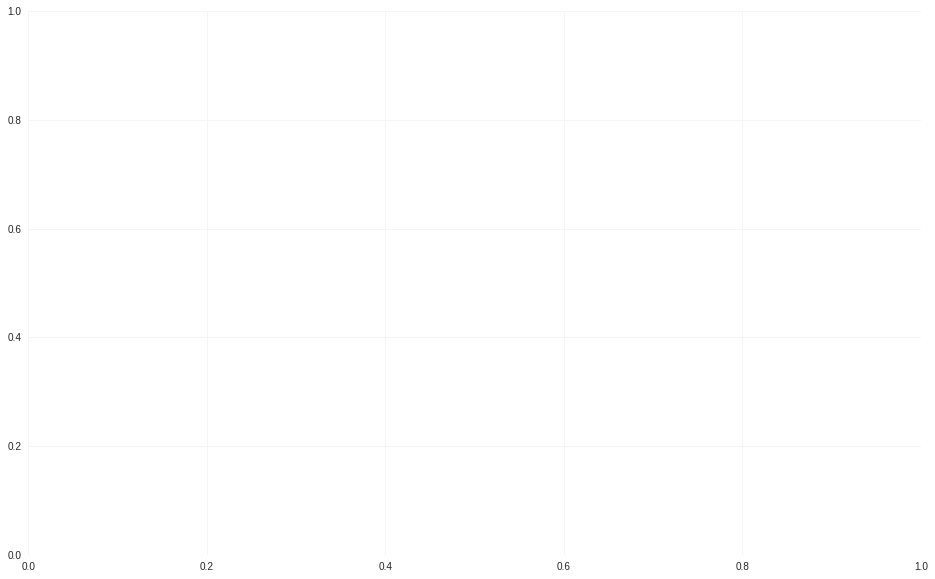

In [26]:
import matplotlib.cm as cm
import operator as o
import itertools
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'whitesmoke'})

fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(16,10)

dpoints=np.transpose(np.hstack([
            np.vstack([['FQI w/ Extra-Trees']*len(use), [feats[x] for x in use], imp1]),
            np.vstack([['Neural Fitted-Q']*len(use), [feats[x] for x in use], imp2])

        ]))

def barplot(ax, dpoints):
    '''
    Create a barchart for data across different categories with
    multiple conditions for each category.
    
    @param ax: The plotting axes from matplotlib.
    @param dpoints: The data set as an (n, 3) numpy array
    '''
    palette = itertools.cycle(sns.color_palette('Set2'))
    palette = itertools.cycle([sns.color_palette('Set2')[0],sns.color_palette('Set2')[4]])

    # Aggregate the conditions and the categories according to their
    # mean values
    conditions = [(c, np.mean(dpoints[dpoints[:,0] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,0])]
    categories = [(c, np.mean(dpoints[dpoints[:,1] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,1])]
    
    # sort the conditions, categories and data so that the bars in
    # the plot will be ordered by category and condition
    conditions = [c[0] for c in sorted(conditions, key=o.itemgetter(1))]
    categories = [c[0] for c in sorted(categories, key=o.itemgetter(1))]
    
    dpoints = np.array(sorted(dpoints, key=lambda x: categories.index(x[1])))

    # the space between each set of bars
    space = 0.3
    n = len(conditions)
    width = 0.3
    height = (1 - space) / (len(conditions))
    
    # Create a set of bars at each position
    for i,cond in enumerate(conditions):
        indeces = range(1, len(categories)+1)
        vals = dpoints[dpoints[:,0] == cond][:,2].astype(np.float)
        pos = [j - (1 - space) / 2. + i * height for j in indeces]
        ax.barh(pos, vals, height=width, label=cond, color=next(palette))
    
    # Set the x-axis tick labels to be equal to the categories
    ax.set_yticks(indeces)
    ax.set_yticklabels(categories, size=12)
    #plt.setp(plt.xticks()[1], rotation=0)
    
    # Add the axis labels
    ax.set_xlabel("Feature Importance",size=12)
    ax.set_ylabel("", size=12)
    ax.set_ylim([0, len(categories)+1])
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='lower right',fontsize=12)
        
barplot(ax, dpoints)
plt.show()

In [ ]:
allTestStates = np.concatenate([testStates[h] for h in testPts])
allTestActions = np.concatenate([testActions[h] for h in testPts])

In [ ]:
def piHosp(h, adim): 
    pi = np.transpose(testActions[h])[adim]
    return pi
    
def piRL(h, adim, policyTree):
    test = np.transpose(np.transpose(testStates[h])[:24])
    pi = np.transpose(policyTree.predict_proba(test))[0]
    #pi = possibleActions[np.transpose(policyTree.predict(test))]
    return pi

figure(figsize=[10,10])
h=1800
h=1509
#h=1947
#h=2020
#h=1996
for h in range(1810,1815):
    figure()
    plot(piHosp(hadms[h], 0),color=sns.color_palette('Set2')[1], linewidth=2)
    plot(piRL(hadms[h],0,ptree2),color=sns.color_palette('Set2')[0], linewidth=2)
    plot(piRL(hadms[h],0,ptree1),color=sns.color_palette('Set2')[4], linewidth=2)
    #plot(np.transpose(clfbb.predict_proba(sclb.transform(samplesb[hadms[h]])))[1], color=sns.color_palette('Set2', 10)[2], linewidth=1, linestyle='-.')

    plt.axhline(y=0.5, color=sns.color_palette('Set2',8)[6], linestyle=':')
    ylabel('$\mathcal{Pr } $ (Ventilator Need)', fontsize=14)
    xlabel('Admission time (hours)', fontsize=14)
    plt.legend(['Vent on/off','NFQ','FQIT','Logistic Regression'], bbox_to_anchor=(0., 0.01, 1., 2), loc=3,fontsize=14 )
    title('Admission '+ str(h), fontsize=14)

In [29]:
## Testing ##

def piHosp(h, adim): 
    pi = np.transpose(testActions[h])[adim]
    return pi
    
def piRL(h, adim, policyTree):
    test = np.transpose(np.transpose(testStates[h])[:24])
    pi = np.transpose(policyTree.predict(test))
    return 1-pi

total = {}; vMatches = {}; sMatches = {}
frac_vMatches = []; frac_sMatches = []; 
fqi = True
for h in testPts:
    total[h] = len(piHosp(h, 0))
    vMatches[h] = np.where(piHosp(h, 0) - piRL(h, 0, ptree1) == 0)[0]
    sMatches[h] = np.where(abs(piHosp(h, 1) - piRL(h, 1, ptree1)) <= 1)[0]
    frac_vMatches.append(100 * len(vMatches[h])/float(total[h])) 
    frac_sMatches.append(100 * len(sMatches[h])/float(total[h])) 
    
frac_vMatches = np.asarray(frac_vMatches)
frac_sMatches = np.asarray(frac_sMatches)

ValueError: zero-size array to reduction operation minimum which has no identity

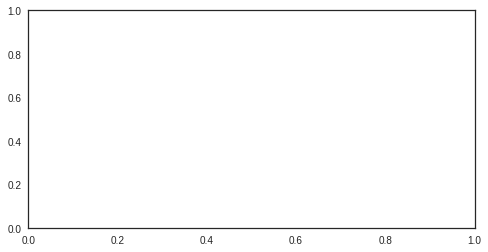

In [30]:
bins = stats.mstats.mquantiles(frac_vMatches, [0, 1./5, 2./5, 3./5, 4./5, 1])
gamma = 0.9
discount = []
for i in range(max([len(testSamples[h]) for h in testPts])):
    discount.append(gamma**i)

bins=[100, 93, 85, 70, 55, 0]    
dist0 = np.where(frac_vMatches >= bins[0])[0]
dist1 = np.where(np.logical_and((frac_vMatches >= bins[1]), (frac_vMatches < bins[0])))[0]
dist2 = np.where(np.logical_and((frac_vMatches >= bins[2]), (frac_vMatches < bins[1])))[0]
dist3 = np.where(np.logical_and((frac_vMatches >= bins[3]), (frac_vMatches < bins[2])))[0]
dist4 = np.where(np.logical_and((frac_vMatches >= bins[4]), (frac_vMatches < bins[3])))[0]
dist5 = np.where(np.logical_and((frac_vMatches >= bins[5]), (frac_vMatches < bins[4])))[0]
vdists = [dist0, dist1, dist2, dist3, dist4, dist5]

os = 1500; finHr = {}; nd=0
for d in vdists:
    finHr[nd] = [sum(array(discount[:len(testRewards[hadms[i+os]][::1])]) * testRewards[hadms[i+os]][::-1]) for i in d]
    
    #finHr[nd] = ([mean(testRewards[hadms[i+os]][:]) for i in d])                   # mean reward 
    #finHr[nd] =  [testSamples[hadms[i+os]][len(testSamples[hadms[i+os]])-1][30] for i in d]   # num intubations
    nd = nd + 1
#for i in np.where([finHr[5][l] == 0 for l in range(len(finHr[5]))])[0]: finHr[5][i] = 1 

plt.style.use('seaborn-white')
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'lightgrey'})

pos = [1, 2, 3, 4, 5, 6]
data = [finHr[i] for i in range(0,6)]
figure(figsize=(8,4))
fig = plt.subplot()
violin_parts = plt.violinplot(data, pos, vert=False, widths=0.9, showmeans=True, showextrema=True, showmedians=False)
fig.set_yticklabels(['','$\Delta_0$','$\Delta_1$','$\Delta_2$','$\Delta_3$','$\Delta_4$','$\Delta_5$'], size=14)
fig.set_xlabel('# Intubations over admission', size=14)
fig.set_xlabel('Discounted cumulative reward over admission', size=14)
fig.set_ylabel('$\Delta(\pi_{FQI}, \pi_{Hosp})$', size=14)

colour0 = sns.color_palette('Set2')[0]
colour1 = sns.color_palette('Set2')[1]

for pc in violin_parts['bodies']: pc.set_facecolor(colour0); pc.set_edgecolor(colour0)
for pc in ['cmeans', 'cmins', 'cmaxes', 'cbars']: violin_parts[pc].set_color(colour0)
plt.show()

In [21]:
mean(finHr[0])


-11.768204004808789

In [22]:
testActions[testPts[369]]

array([[ 1.,  0.],
       [ 1., -1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1., -1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1., -1.],
       [ 1., -1.],
       [ 1.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0., -1.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [23]:
mean(np.concatenate([finHr[i] for i in finHr.keys()]))

-12.718482653047301

In [45]:
def fitTree(samples,targets):
    clf = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=50, random_state=1, warm_start=False)
    clf.fit(samples, targets)
    return clf

empirical_piHosp = fitTree([allTrainStates[s] for s in range(195663)], [allTrainActions[s] for s in range(195663)])


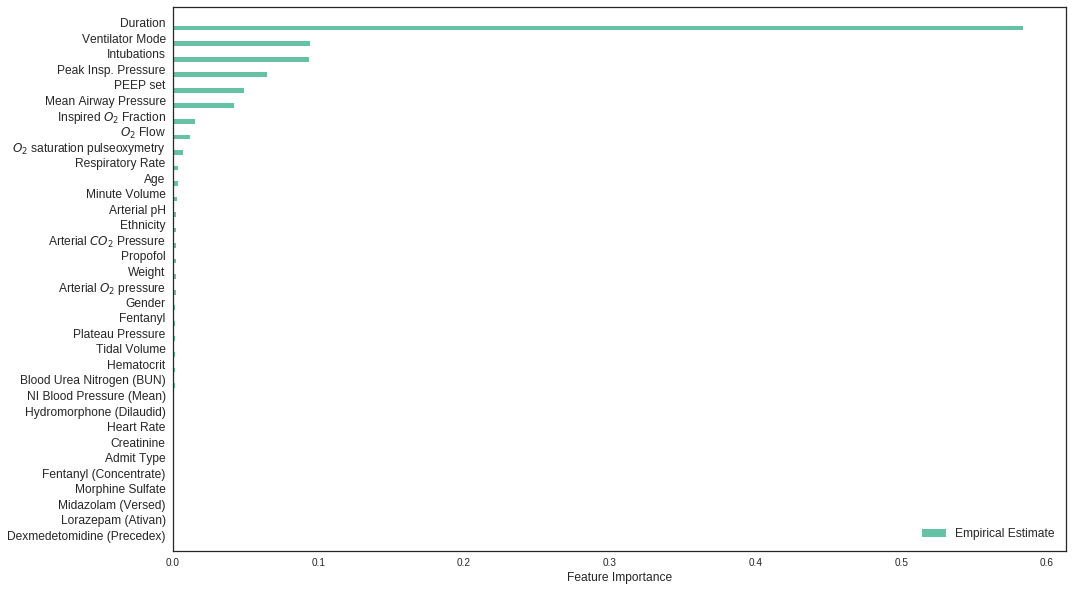

In [60]:
fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(16,10)

dpoints=np.transpose(np.hstack([
            np.vstack([['Empirical Estimate']*len(feats), [feats[x] for x in range(len(feats))], empirical_piHosp.feature_importances_]),
        ]))
barplot(ax, dpoints)
plt.show()

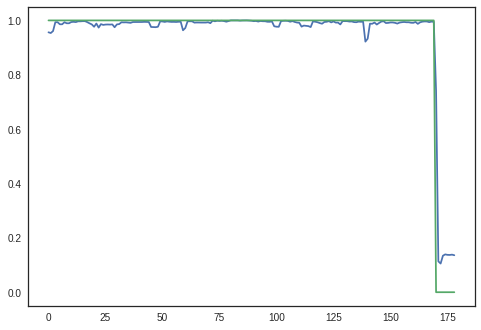

In [46]:
plot(empirical_piHosp.predict([allTrainStates[s] for s in range(179)]))
hold(True)
plot([allTrainActions[s] for s in range(179)])

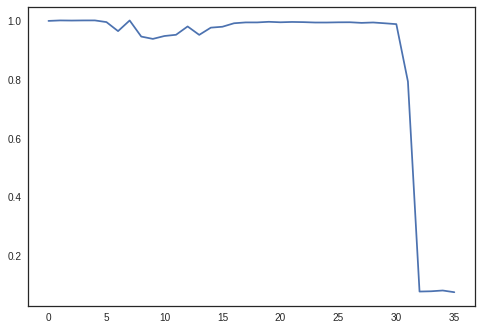

In [69]:
plot(empirical_piHosp.predict(testStates[testPts[2]]))

In [61]:
plot(empirical_piHosp.predict([testStates[h] for h in testPts]))
hold(True)
#plot([testAc[s] for s in range(366,460)])

ValueError: setting an array element with a sequence.

In [28]:
discount

NameError: name 'discount' is not defined

In [39]:
discountedReward = []
for i in range(530):
    discountedReward[i] = array(discount[:len(testRewards[hadms[i+os]][::1])]) * testRewards[hadms[i+os]][::-1]
    

[array(discount[:len(testRewards[hadms[i+os]][::1])]) * testRewards[hadms[i+os]][::-1] for i in range(530)]

IndexError: list assignment index out of range

In [ ]:
# Importance Sampling

for pt in testPts:
    
    